<a href="https://colab.research.google.com/github/evysb/deep_learning_class/blob/main/Melhores_pr%C3%A1ticas_de_treinamento_de_modelos_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
  <tr>
    <td><center style="font-size:300%;">Melhores práticas de treinamento de modelos deep learning</center></td>
    <td><img src="https://logodownload.org/wp-content/uploads/2015/02/puc-rio-logo.gif" width="100"/></td>
  </tr>    
</table>

PhD. Evelyn Batista

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import ParameterGrid

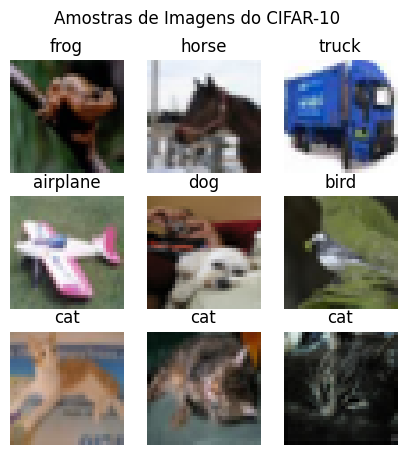

Distribuição das Classes (CIFAR-10):
airplane: 4495 exemplos
automobile: 4540 exemplos
bird: 4481 exemplos
cat: 4514 exemplos
deer: 4481 exemplos
dog: 4512 exemplos
frog: 4481 exemplos
horse: 4514 exemplos
ship: 4480 exemplos
truck: 4502 exemplos


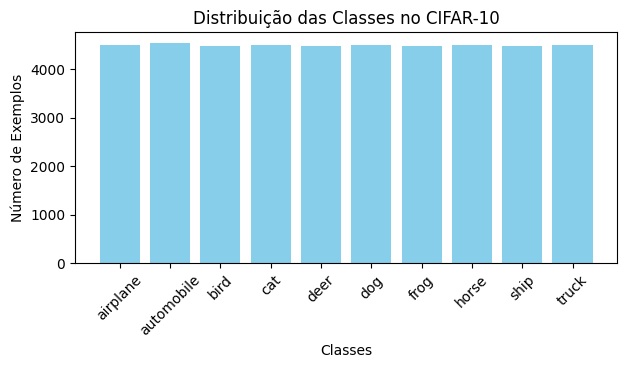

In [7]:

# Passo 1: Preparação dos Dados

# Carregar o dataset CIFAR-10 (já dividido em treino e teste)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Normalizar as imagens para o intervalo [0, 1] ### Mas como vamos usar ImageDataGenerator, vai ser normalizado lá!
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0


# Codificar as classes para uma representação one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Dividir os dados de treino em dados de validação
x_train, x_val = x_train[5000:], x_train[:5000]
y_train, y_val = y_train[5000:], y_train[:5000]

# Análise Exploratória dos Dados
# Visualizar algumas imagens do dataset CIFAR-10
def plot_images(images, labels, classes, title=''):
    plt.figure(figsize=(5, 5))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Definir as classes do CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Exibir 9 imagens aleatórias de treino com suas respectivas classes
plot_images(x_train, y_train, class_names, 'Amostras de Imagens do CIFAR-10')

# Verificar a distribuição das classes
print("Distribuição das Classes (CIFAR-10):")
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
for u, c in zip(unique, counts):
    print(f"{class_names[u]}: {c} exemplos")

# Gráfico de barras para a distribuição das classes
plt.figure(figsize=(7, 3))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Número de Exemplos')
plt.title('Distribuição das Classes no CIFAR-10')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Passo 2: Data Augmentation
# Criar o gerador de dados com aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)





In [9]:
# Passo 3: Escolha da Arquitetura do Modelo
# Carregar a arquitetura VGG16 pré-treinada, sem a camada de classificação final (fully connected)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Congelar as camadas convolucionais para evitar que sejam atualizadas durante o fine-tuning
base_model.trainable = False

# Construção do modelo com VGG16 como base
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Regularização L2
    layers.Dropout(0.5),  # Regularização com Dropout
    layers.Dense(10, activation='softmax')  # Camada final de classificação (10 classes para o CIFAR-10)
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir o callback para salvar o melhor modelo durante o treinamento
checkpoint = ModelCheckpoint('/content/best_vgg16_cifar10_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorar a perda na validação
    patience=20,          # Número de épocas sem melhora para parar
    restore_best_weights=True  # Restaurar os melhores pesos
)

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=x_train.shape[0] // 64,
    epochs=10,
    validation_data=val_generator,
    validation_steps=x_val.shape[0] // 64,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
699/703 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1809 - loss: 4.6955
Epoch 1: val_loss improved from inf to 2.62082, saving model to /content/best_vgg16_cifar10_model.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.1814 - loss: 4.6895 - val_accuracy: 0.4060 - val_loss: 2.6208
Epoch 2/10
  1/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3438 - loss: 2.7838

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.62082
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 2.7838 - val_accuracy: 0.2500 - val_loss: 2.6688
Epoch 3/10
699/703 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3400 - loss: 2.5411
Epoch 3: val_loss improved from 2.62082 to 2.03903, saving model to /content/best_vgg16_cifar10_model.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.3401 - loss: 2.5401 - val_accuracy: 0.4569 - val_loss: 2.0390
Epoch 4/10
  1/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3594 - loss: 2.2358
Epoch 4: val_loss improved from 2.03903 to 1.95845, saving model to /content/best_vgg16_cifar10_model.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.3594 - loss: 2.2358 - val_accuracy: 0.3750 - val_loss: 1.9585
Epoch 5/10
697/703 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3835 - loss: 2.1189
Epoch 5: val_loss improved from 1.95845 to 1.85754, saving model to /content/best_vgg16_cifar10_model.keras
703/703 ━━━━━

In [10]:
# Passo 4: Salvar o Melhor Modelo
# O melhor modelo já foi salvo durante o treinamento através do ModelCheckpoint
# Carregar o melhor modelo (caso precise)
best_model = tf.keras.models.load_model('best_vgg16_cifar10_model.keras')

313/313 - 4s - 13ms/step - accuracy: 0.2984 - loss: 24.3183
Model Test Accuracy: 0.2984


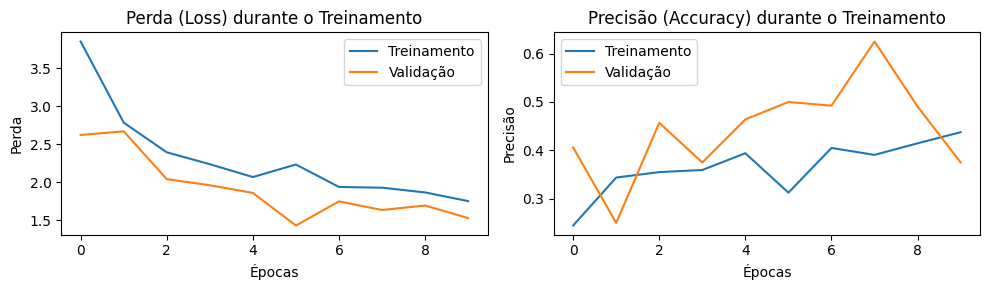

In [11]:
# Passo 5: Avaliar o modelo final
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f'Model Test Accuracy: {test_acc:.4f}')


# Plotar os Gráficos de Performance

# Plotar a evolução da perda (loss)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss) durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotar a evolução da precisão (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Precisão (Accuracy) durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Passo 6: Melhorar os Hiperparâmetros
def build_model(learning_rate, dense_units, dropout_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Congelar a base

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Definir a Busca em Grade (Grid Search)
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'dense_units': [128, 256],
    'dropout_rate': [0.3, 0.5]
}

# Gerar todas as combinações possíveis de parâmetros
grid = ParameterGrid(param_grid)

best_model = None
best_val_accuracy = 0
best_params = {}

# Treinar Modelos com Diferentes Hiperparâmetros
for params in grid:
    print(f"Treinando modelo com parâmetros: {params}")

    model = build_model(learning_rate=params['learning_rate'],
                        dense_units=params['dense_units'],
                        dropout_rate=params['dropout_rate'])

    # Salvar o modelo com o melhor desempenho de validação
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    early_stopping = EarlyStopping(
                      monitor='val_loss',  # Monitorar a perda na validação
                      patience=20,          # Número de épocas sem melhora para parar
                      restore_best_weights=True  # Restaurar os melhores pesos
                  )

    # Treinamento do modelo
    history = model.fit(
        train_generator,
        steps_per_epoch=x_train.shape[0] // 64,
        epochs=5,  # Reduzido para fins de experimentação rápida
        validation_data=val_generator,
        validation_steps=x_val.shape[0] // 64,
        callbacks=[checkpoint, early_stopping]
    )

    # Avaliar a precisão de validação
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Modelo com parâmetros {params} obteve precisão de validação: {val_accuracy:.4f}")

    # Verificar se o modelo atual tem melhor desempenho
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        model.save('best_of_the_best_model.keras')
        best_params = params



Treinando modelo com parâmetros: {'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Epoch 1/5
697/703 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1799 - loss: 3.7218
Epoch 1: val_accuracy improved from -inf to 0.39744, saving model to best_model.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.1805 - loss: 3.7166 - val_accuracy: 0.3974 - val_loss: 2.3938
Epoch 2/5
  1/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3125 - loss: 2.4061
Epoch 2: val_accuracy did not improve from 0.39744
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3125 - loss: 2.4061 - val_accuracy: 0.3750 - val_loss: 2.3085
Epoch 3/5
699/703 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3398 - loss: 2.3466
Epoch 3: val_accuracy improved from 0.39744 to 0.44331, saving model to best_model.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.3398 - loss: 2.3459 - val_accuracy: 0.4433 - val_loss: 1.9688
Epoch 4/5
  1/703 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

313/313 - 3s - 9ms/step - accuracy: 0.3009 - loss: 31.6055

Melhor Modelo - Precisão no Conjunto de Teste: 0.3009


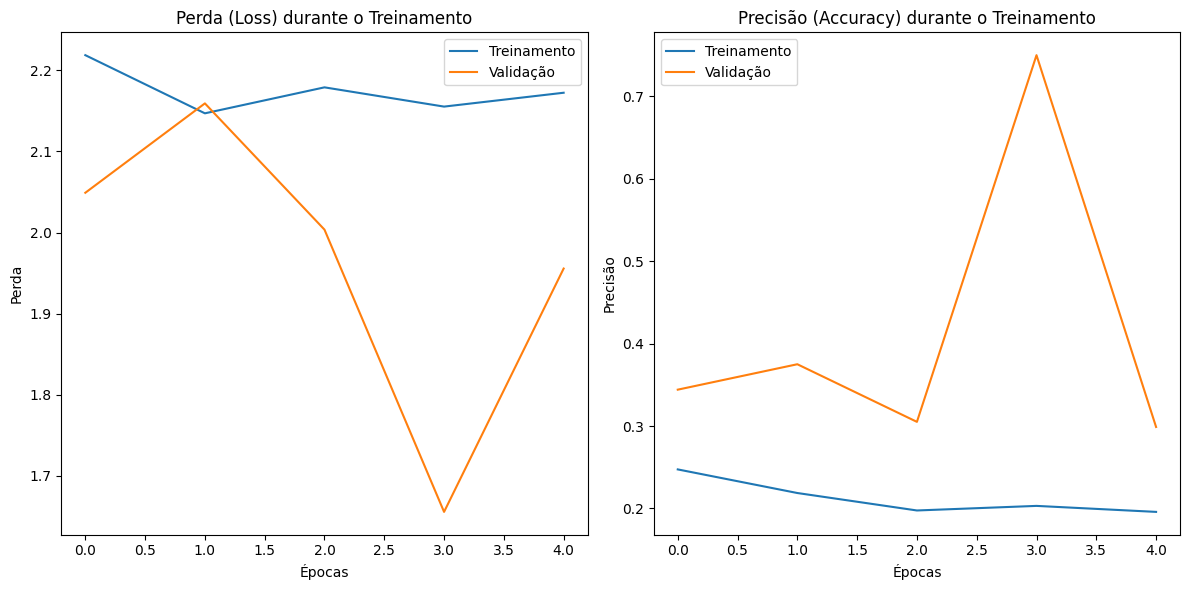


Melhores parâmetros encontrados: {'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001}


In [13]:
# Carregar o melhor modelo salvo
best_model = tf.keras.models.load_model('best_of_the_best_model.keras')

# Avaliar o modelo final no conjunto de teste
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f"\nMelhor Modelo - Precisão no Conjunto de Teste: {test_acc:.4f}")

# Plotar os Gráficos de Performance para o Melhor Modelo

# Plotar a evolução da perda (loss) para o melhor modelo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss) durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotar a evolução da precisão (accuracy) para o melhor modelo
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Precisão (Accuracy) durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMelhores parâmetros encontrados: {best_params}")